# Wind Layout Optimization

In [42]:
import os
from time import time
from pathlib import Path

import yaml
import json
import numpy as np
from matplotlib import pyplot as plt
from pyoptsparse import NSGA2, ALPSO, IPOPT, SNOPT
from pyoptsparse import Optimization

from hopp import ROOT_DIR
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site
from hopp.simulation.hybrid_simulation import HybridSimulation
from hopp.simulation.technologies.layout.wind_layout import WindCustomParameters
from hopp.simulation.technologies.layout.wind_layout_tools import create_grid
from hopp.utilities.log import hybrid_logger as logger
from hopp.utilities.keys import set_nrel_key_dot_env

In [43]:
# Set API key
set_nrel_key_dot_env()

In [44]:
ROTOR_D = 126
N_TURBS = 6

## Define HOPP system functions

In [45]:
def load_config(path):
    with open(path, 'r') as f:
        return yaml.load(f, yaml.SafeLoader)

In [46]:
def create_verts(x0, y0, w, h):
    verts = [
        [x0, y0],
        [x0+w, y0],
        [x0+w, y0+h],
        [x0, y0+h]
    ]
    return verts

In [47]:
def create_site(data, **kwargs):
    solar_resource_file = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
    wind_resource_file = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
    prices_file = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv";
    
    site = SiteInfo(
        data, 
        solar_resource_file=solar_resource_file, 
        wind_resource_file=wind_resource_file, 
        grid_resource_file=prices_file,
        **kwargs
    )

    return site

In [48]:
def create_layout(site, rotor_diameter=126):
    turbine_positions = create_grid(
        site.polygon,
        site.polygon.centroid,
        0, # angle
        ROTOR_D*4, # intrarow spacing
        ROTOR_D*4, # interrow spacing
        0, # row phase offset
        max_sites = N_TURBS
    )

    return turbine_positions

In [71]:
def plot_layout(site, x, y):
    fig, ax = site.plot()
    ax.scatter(x, y)

In [50]:
def create_hybrid_plant(site, tech_keys=None):
    tech_keys = tech_keys or ["wind", "grid"]

    hybrid_config = {}

    # only use desired tech
    for k in tech_keys:
        hybrid_config[k] = technologies[k]

    # create system model
    hybrid_plant = HybridSimulation(hybrid_config, site)
    hybrid_plant.ppa_price = 0.01
    # hybrid_plant.pv.dc_degradation = [0] * 25

    return hybrid_plant

## Define Optimization functions

In [51]:
def create_distance_cons(opt_prob, x_coords, y_coords):
    min_distance = 2 * ROTOR_D
    
    for i in range(N_TURBS):
        for j in range(i+1, N_TURBS):  # only look at pairs once
            constraint_name = f"distance_{i}_{j}"
            opt_prob.addConGroup(constraint_name, 1, lower=min_distance)  # Add a group for each constraint

In [52]:
def setup_opt(layout, opt="snopt"):
    # initialize optimization object
    opt_prob = Optimization("Wind Farm Layout Problem", objective)

    x_coords = [t.x for t in layout]
    y_coords = [t.y for t in layout]
    
    opt_prob.addVarGroup("x_coords", N_TURBS, lower=0, upper=site_w, value=x_coords)
    opt_prob.addVarGroup("y_coords", N_TURBS, lower=0, upper=site_h, value=y_coords)
    
    create_distance_cons(opt_prob, x_coords, y_coords)

    # add objective
    opt_prob.addObj("obj")

    # set up optimizer
    optimizer_mapping = {
        "nsga2": (NSGA2, {"PopSize": 10, "maxGen": 10}),
        "alpso": (ALPSO, {"SwarmSize": 5, "maxOuterIter": 10}),
        "snopt": (SNOPT, {
            "Verify level": 0,
            "Major optimality tolerance": 1E-6,
        }),
        "ipopt": (IPOPT, {})
    }

    optimizer_class, opt_options = optimizer_mapping.get(opt, (None, None))
    if optimizer_class:
        opt = optimizer_class(options=opt_options)
    else:
        raise ValueError(f"Unknown optimizer: {opt}")

    return opt, opt_prob

In [53]:
# set up objective function
def objective(xdict):
    funcs = {}
    
    x_coords = np.asarray(xdict["x_coords"])
    y_coords = np.asarray(xdict["y_coords"])

    floris_config = load_config("floris_input.yaml")
    floris_config["farm"]["layout_x"] = x_coords
    floris_config["farm"]["layout_y"] = y_coords
    
    technologies["wind"]["floris_config"] = floris_config
    hybrid_plant = create_hybrid_plant(site)

    print("x: ", x_coords)
    print("y: ", y_coords)

    # run simulation
    hybrid_plant.simulate(25)
    
    # get result
    funcs["obj"] = -hybrid_plant.annual_energies.hybrid
    
    # apply constraints
    for i in range(N_TURBS):
        for j in range(i+1, N_TURBS):  # only look at pairs once
            con_name = f"distance_{i}_{j}"
            funcs[con_name] = ((x_coords[i]-x_coords[j])**2 + (y_coords[i]-y_coords[j])**2)**0.5
    
    # set fail flag
    fail = False
    return funcs, fail

## System configuration

In [54]:
# Set wind, solar, and interconnection capacities (in MW)
solar_size_mw = 50
turbine_rating_kw = 5000
wind_size_mw = N_TURBS * turbine_rating_kw
interconnection_size_mw = 50

floris_config = "floris_input.yaml"

# specify which technologies to include in the system
technologies = {
    'pv': {
        'system_capacity_kw': solar_size_mw * 1000
    },
    'wind': {
        'model_name': 'floris',
        'num_turbines': wind_size_mw,
        'turbine_rating_kw': turbine_rating_kw,
        'timestep': [0,8760],
    },
    'battery': {
        'system_capacity_kwh': 100,
        'system_capacity_kw': 100
    },
    'grid': {
        'interconnect_kw': interconnection_size_mw * 1000
    }
}

In [55]:
site_data = flatirons_site
site_w = 1200
site_h = 1200
verts = create_verts(0, 0, site_w, site_h)
site_data["site_boundaries"]["verts"] = verts
site = create_site(site_data)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x (m)', ylabel='y (m)'>)

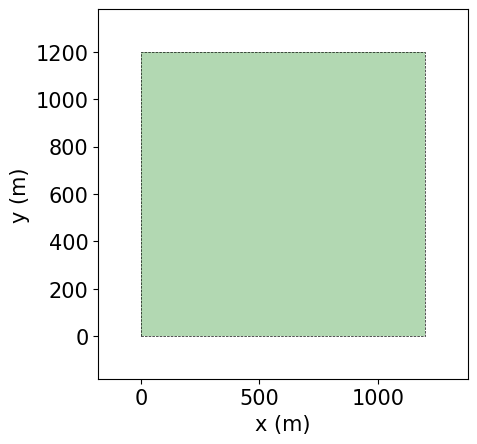

In [56]:
site.plot()

In [57]:
layout = create_layout(site, N_TURBS)

In [69]:
xs = [v.x for v in layout]
xy = [v.y for v in layout]

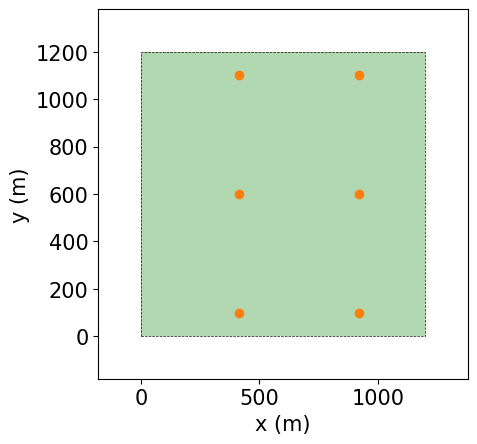

In [72]:
plot_layout(site, xs, xy)

## Run Opt

In [59]:
opt, opt_prob = setup_opt(layout)

In [60]:
print(opt_prob)



Optimization Problem -- Wind Farm Layout Problem
    Objective Function: objective


   Objectives
      Index  Name            Value
          0  obj     0.000000E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name         Type      Lower Bound            Value      Upper Bound     Status
          0  x_coords_0      c     0.000000E+00     4.149437E+02     1.200000E+03           
          1  x_coords_1      c     0.000000E+00     9.189437E+02     1.200000E+03           
          2  x_coords_2      c     0.000000E+00     4.149437E+02     1.200000E+03           
          3  x_coords_3      c     0.000000E+00     9.189437E+02     1.200000E+03           
          4  x_coords_4      c     0.000000E+00     4.149437E+02     1.200000E+03           
          5  x_coords_5      c     0.000000E+00     9.189437E+02     1.200000E+03           
          6  y_coords_0      c     0.000000E+00     9.600000E+01     1.200000E+03           
          7  y_coords_1     

In [61]:
if os.path.exists("./SNOPT_print.out"):
    os.remove("./SNOPT_print.out")

if os.path.exists("./SNOPT_summary.out"):
    os.remove("./SNOPT_summary.out")

In [62]:
sol = opt(opt_prob, sens="FD")

FLORIS is the system model...
x:  [414.94372512 918.94372512 414.94372512 918.94372512 414.94372512
 918.94372512]
y:  [  96.   96.  600.  600. 1104. 1104.]
Simulating wind farm output in FLORIS...
Wind annual energy:  100073644.23976208
FLORIS is the system model...
x:  [414.94372612 918.94372512 414.94372512 918.94372512 414.94372512
 918.94372512]
y:  [  96.   96.  600.  600. 1104. 1104.]
Simulating wind farm output in FLORIS...
Wind annual energy:  100073663.95948447
FLORIS is the system model...
x:  [414.94372512 918.94372612 414.94372512 918.94372512 414.94372512
 918.94372512]
y:  [  96.   96.  600.  600. 1104. 1104.]
Simulating wind farm output in FLORIS...
Wind annual energy:  100073626.77020955
FLORIS is the system model...
x:  [414.94372512 918.94372512 414.94372612 918.94372512 414.94372512
 918.94372512]
y:  [  96.   96.  600.  600. 1104. 1104.]
Simulating wind farm output in FLORIS...
Wind annual energy:  100073634.86222312
FLORIS is the system model...
x:  [414.94372512 

x:  [415.12001559 918.3651344  413.70073719 918.36559267 413.70073619
 916.94585581]
y:  [  95.9338501    95.71242622  599.17897037  599.99954764 1103.24557129
 1104.28757378]
Simulating wind farm output in FLORIS...
Wind annual energy:  100087083.8676545
FLORIS is the system model...
x:  [415.12001559 918.3651344  413.70073619 918.36559367 413.70073619
 916.94585581]
y:  [  95.9338501    95.71242622  599.17897037  599.99954764 1103.24557129
 1104.28757378]
Simulating wind farm output in FLORIS...
Wind annual energy:  100087089.09981869
FLORIS is the system model...
x:  [415.12001559 918.3651344  413.70073619 918.36559267 413.70073719
 916.94585581]
y:  [  95.9338501    95.71242622  599.17897037  599.99954764 1103.24557129
 1104.28757378]
Simulating wind farm output in FLORIS...
Wind annual energy:  100087102.43386993
FLORIS is the system model...
x:  [415.12001559 918.3651344  413.70073619 918.36559267 413.70073619
 916.94585681]
y:  [  95.9338501    95.71242622  599.17897037  599.999

Wind annual energy:  100089234.0996147
FLORIS is the system model...
x:  [415.68990837 919.27994618 414.26868053 919.27998522 414.26868053
 917.85871941]
y:  [  95.86268664   95.84382393  599.45272457  600.47729485 1103.11274308
 1104.15617607]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089229.85930605
FLORIS is the system model...
x:  [415.68990837 919.27994618 414.26868053 919.27998522 414.26868053
 917.85871841]
y:  [  95.86268764   95.84382393  599.45272457  600.47729485 1103.11274308
 1104.15617607]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089219.7420274
FLORIS is the system model...
x:  [415.68990837 919.27994618 414.26868053 919.27998522 414.26868053
 917.85871841]
y:  [  95.86268664   95.84382493  599.45272457  600.47729485 1103.11274308
 1104.15617607]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089199.1421467
FLORIS is the system model...
x:  [415.68990837 919.27994618 414.26868053 919.27998522 414.26868053
 9

Wind annual energy:  100089452.16870037
FLORIS is the system model...
x:  [415.74294292 919.36507909 414.32153376 919.36507912 414.32153376
 917.94366993]
y:  [  95.85606412   95.85605188  599.47820129  600.52175428 1103.10038201
 1104.14394812]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089479.10045359
FLORIS is the system model...
x:  [415.74294292 919.36507909 414.32153376 919.36507912 414.32153376
 917.94366993]
y:  [  95.85606412   95.85605188  599.47820029  600.52175528 1103.10038201
 1104.14394812]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089391.16327333
FLORIS is the system model...
x:  [415.74294292 919.36507909 414.32153376 919.36507912 414.32153376
 917.94366993]
y:  [  95.85606412   95.85605188  599.47820029  600.52175428 1103.10038301
 1104.14394812]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089439.60088915
FLORIS is the system model...
x:  [415.74294292 919.36507909 414.32153376 919.36507912 414.32153376

Wind annual energy:  100089369.9480737
FLORIS is the system model...
x:  [415.74290442 919.36501729 414.32149539 919.36501734 414.32149539
 917.94360826]
y:  [  95.85606893   95.856043    599.4781818   600.52172201 1103.10039098
 1104.143958  ]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089420.58828172
FLORIS is the system model...
x:  [415.74292481 919.36505002 414.32151571 919.36505006 414.32151571
 917.94364092]
y:  [  95.85606638   95.8560477   599.4781916   600.5217391  1103.10038623
 1104.1439523 ]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089399.04127751
FLORIS is the system model...
x:  [415.74292581 919.36505002 414.32151571 919.36505006 414.32151571
 917.94364092]
y:  [  95.85606638   95.8560477   599.4781916   600.5217391  1103.10038623
 1104.1439523 ]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089396.14247365
FLORIS is the system model...
x:  [415.74292481 919.36505102 414.32151571 919.36505006 414.32151571


Wind annual energy:  100089408.28245018
FLORIS is the system model...
x:  [415.74294291 919.36508007 414.32153375 919.3650791  414.32153375
 917.94366991]
y:  [  95.85606412   95.85605187  599.47820029  600.52175428 1103.10038201
 1104.14394813]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089357.40904945
FLORIS is the system model...
x:  [415.74294291 919.36507907 414.32153475 919.3650791  414.32153375
 917.94366991]
y:  [  95.85606412   95.85605187  599.47820029  600.52175428 1103.10038201
 1104.14394813]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089420.03584813
FLORIS is the system model...
x:  [415.74294291 919.36507907 414.32153375 919.3650801  414.32153375
 917.94366991]
y:  [  95.85606412   95.85605187  599.47820029  600.52175428 1103.10038201
 1104.14394813]
Simulating wind farm output in FLORIS...
Wind annual energy:  100089402.61689943
FLORIS is the system model...
x:  [415.74294291 919.36507907 414.32153375 919.3650791  414.32153475

Wind annual energy:  100079304.5437951
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453839
 800.12407627]
y:  [ 148.90121031    0.          948.00001165  251.99999936 1200.
  505.54409721]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079302.53215468
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407727]
y:  [ 148.90121031    0.          948.00001165  251.99999936 1200.
  505.54409721]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079206.3808302
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407627]
y:  [ 148.90121131    0.          948.00001165  251.99999936 1200.
  505.54409721]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079293.18541594
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407627]
y:  [1.489

FLORIS is the system model...
x:  [  0.         252.88597948   0.         251.6063463  536.49962305
 788.02630257]
y:  [1.45660365e+02 1.00000000e-06 9.44100589e+02 2.52015428e+02
 1.20000000e+03 5.09555791e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100030756.3672955
FLORIS is the system model...
x:  [  0.         252.88597948   0.         251.6063463  536.49962305
 788.02630257]
y:  [ 145.6603647     0.          944.10058976  252.0154282  1200.
  509.55579065]
Simulating wind farm output in FLORIS...
Wind annual energy:  100030770.14075345
FLORIS is the system model...
x:  [  0.         252.88597948   0.         251.6063463  536.49962305
 788.02630257]
y:  [ 145.6603647     0.          944.10058876  252.0154292  1200.
  509.55579065]
Simulating wind farm output in FLORIS...
Wind annual energy:  100030700.14052826
FLORIS is the system model...
x:  [  0.         252.88597948   0.         251.6063463  536.49962305
 788.02630257]
y:  [ 145.6603647     0.          9

x:  [  0.         252.00012067   0.         253.43855785 546.68381594
 800.12321933]
y:  [ 148.90098074    0.          947.99973544  252.00000045 1200.000001
  505.54438138]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079266.1410797
FLORIS is the system model...
x:  [  0.         252.00012067   0.         253.43855785 546.68381594
 800.12321933]
y:  [ 148.90098074    0.          947.99973544  252.00000045 1200.
  505.54438238]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079291.17556544
FLORIS is the system model...
x:  [  0.         252.00005795   0.         253.43868758 546.68453701
 800.12407582]
y:  [ 148.90121019    0.          948.00001151  251.99999936 1200.
  505.54409736]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079292.63784303
FLORIS is the system model...
x:  [1.00000000e-06 2.52000058e+02 0.00000000e+00 2.53438688e+02
 5.46684537e+02 8.00124076e+02]
y:  [ 148.90121019    0.          948.00001151  251.99999936 

Wind annual energy:  97736634.74708459
FLORIS is the system model...
x:  [  0.         299.87489789   0.         164.28625393 520.90324229
 188.98423529]
y:  [   0.           12.13621749  989.60130955  264.91438121 1200.
  810.61011202]
Simulating wind farm output in FLORIS...
Wind annual energy:  97736629.40776138
FLORIS is the system model...
x:  [0.00000000e+00 2.99874897e+02 1.00000000e-06 1.64286254e+02
 5.20903242e+02 1.88984235e+02]
y:  [   0.           12.13621749  989.60130955  264.91438121 1200.
  810.61011202]
Simulating wind farm output in FLORIS...
Wind annual energy:  97736634.24742593
FLORIS is the system model...
x:  [  0.         299.87489689   0.         164.28625493 520.90324229
 188.98423529]
y:  [   0.           12.13621749  989.60130955  264.91438121 1200.
  810.61011202]
Simulating wind farm output in FLORIS...
Wind annual energy:  97736631.73358923
FLORIS is the system model...
x:  [  0.         299.87489689   0.         164.28625393 520.90324329
 188.98423529]


Wind annual energy:  100054310.86594693
FLORIS is the system model...
x:  [  0.         252.83890606   0.         251.87658623 546.2328065
 789.41587266]
y:  [1.46292209e+02 2.12647056e-01 9.48728937e+02 2.52226281e+02
 1.20000000e+03 5.10889370e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100054316.84405181
FLORIS is the system model...
x:  [  0.         252.83890606   0.         251.87658623 546.2328055
 789.41587366]
y:  [1.46292209e+02 2.12647056e-01 9.48728937e+02 2.52226281e+02
 1.20000000e+03 5.10889370e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100054482.71720971
FLORIS is the system model...
x:  [  0.         252.83890606   0.         251.87658623 546.2328055
 789.41587266]
y:  [1.46292210e+02 2.12647056e-01 9.48728937e+02 2.52226281e+02
 1.20000000e+03 5.10889370e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100054319.5405119
FLORIS is the system model...
x:  [  0.         252.83890606   0.         251.8765862

Wind annual energy:  100079271.14173533
FLORIS is the system model...
x:  [  0.         252.00031286   0.         253.43821289 546.6844001
 800.12082179]
y:  [1.48900418e+02 6.46285602e-05 9.48000233e+02 2.52000068e+02
 1.20000000e+03 5.05545722e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079149.59722759
FLORIS is the system model...
x:  [  0.         252.00031286   0.         253.43821289 546.6844001
 800.12082179]
y:  [1.48900417e+02 6.56285602e-05 9.48000233e+02 2.52000068e+02
 1.20000000e+03 5.05545722e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079163.35483724
FLORIS is the system model...
x:  [  0.         252.00031286   0.         253.43821289 546.6844001
 800.12082179]
y:  [1.48900417e+02 6.46285602e-05 9.48000234e+02 2.52000068e+02
 1.20000000e+03 5.05545722e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079138.75927055
FLORIS is the system model...
x:  [  0.         252.00031286   0.         253.438212

Wind annual energy:  100079289.70444964
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407627]
y:  [1.48901210e+02 1.07683133e-11 9.48000013e+02 2.51999999e+02
 1.20000000e+03 5.05544097e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079311.60624968
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407627]
y:  [1.48901210e+02 1.07683133e-11 9.48000012e+02 2.52000000e+02
 1.20000000e+03 5.05544097e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079280.48571537
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407627]
y:  [1.48901210e+02 1.07683133e-11 9.48000012e+02 2.51999999e+02
 1.20000000e+03 5.05544097e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079291.56826362
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.438

Wind annual energy:  97174186.58308233
FLORIS is the system model...
x:  [  0.         431.33458518   0.          73.26393252 245.97354762
 160.09130149]
y:  [   0.          234.61828754 1131.64077771  488.66656375 1200.
  900.40046356]
Simulating wind farm output in FLORIS...
Wind annual energy:  97174158.08060184
FLORIS is the system model...
x:  [  0.         258.76238068   0.         246.64468168 535.34536694
 775.98980458]
y:  [ 143.28646305    8.84695553  954.92471351  260.92419105 1200.
  520.43328911]
Simulating wind farm output in FLORIS...
Wind annual energy:  100062159.52937244
FLORIS is the system model...
x:  [1.00000000e-06 2.58762381e+02 0.00000000e+00 2.46644682e+02
 5.35345367e+02 7.75989805e+02]
y:  [ 143.28646305    8.84695553  954.92471351  260.92419105 1200.
  520.43328911]
Simulating wind farm output in FLORIS...
Wind annual energy:  100062159.73392309
FLORIS is the system model...
x:  [  0.         258.76238168   0.         246.64468168 535.34536694
 775.98980458

Wind annual energy:  100079230.12130012
FLORIS is the system model...
x:  [  0.         252.00197965   0.         253.43675792 546.68131668
 800.11722132]
y:  [1.48899616e+02 2.51283623e-03 9.48001979e+02 2.52002534e+02
 1.20000000e+03 5.05548326e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079210.34326714
FLORIS is the system model...
x:  [0.00000000e+00 2.52001979e+02 1.00000000e-06 2.53436758e+02
 5.46681317e+02 8.00117221e+02]
y:  [1.48899616e+02 2.51283623e-03 9.48001979e+02 2.52002534e+02
 1.20000000e+03 5.05548326e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079218.08917546
FLORIS is the system model...
x:  [  0.         252.00197865   0.         253.43675892 546.68131668
 800.11722132]
y:  [1.48899616e+02 2.51283623e-03 9.48001979e+02 2.52002534e+02
 1.20000000e+03 5.05548326e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079198.41122404
FLORIS is the system model...
x:  [  0.         252.00197865   0.    

Wind annual energy:  100079285.09837973
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868865 546.68453739
 800.12407627]
y:  [1.48901210e+02 1.58270343e-09 9.48000012e+02 2.51999999e+02
 1.20000000e+03 5.05544097e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079248.32563926
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453839
 800.12407627]
y:  [1.48901210e+02 1.58270343e-09 9.48000012e+02 2.51999999e+02
 1.20000000e+03 5.05544097e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079263.34294768
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407727]
y:  [1.48901210e+02 1.58270343e-09 9.48000012e+02 2.51999999e+02
 1.20000000e+03 5.05544097e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079154.74559711
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.438

Wind annual energy:  100079149.98929614
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407727]
y:  [1.48901210e+02 1.32085406e-11 9.48000012e+02 2.51999999e+02
 1.20000000e+03 5.05544097e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079270.10161652
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407627]
y:  [1.48901211e+02 1.32085406e-11 9.48000012e+02 2.51999999e+02
 1.20000000e+03 5.05544097e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079159.3172495
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.43868765 546.68453739
 800.12407627]
y:  [1.48901210e+02 1.00001321e-06 9.48000012e+02 2.51999999e+02
 1.20000000e+03 5.05544097e+02]
Simulating wind farm output in FLORIS...
Wind annual energy:  100079163.84184231
FLORIS is the system model...
x:  [  0.         252.00005792   0.         253.4386

## Analysis

In [63]:
print(sol)



Optimization Problem -- Wind Farm Layout Problem
    Objective Function: objective

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                78948.5477
       User Objective Time :    1606.0069
       User Sensitivity Time : 77342.1892
       Interface Time :            0.1265
       Opt Solver Time:            0.2251
    Calls to Objective Function :      38
    Calls to Sens Function :           37


   Objectives
      Index  Name            Value
          0  obj    -1.000793E+08

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name         Type      Lower Bound            Value      Upper Bound     Status
          0  x_coords_0      c     0.000000E+00     0.000000E+00     1.200000E+03          l
          1  x_coords_1      c     0.000000E+00     2.520001E+02     1.200000E+03           
          2  x_coords_2      c     0.000000E+00     0.000000E+00     1.200000E+03          l
         

In [68]:
x_coords = sol.xStar["x_coords"]
y_coords = sol.xStar["y_coords"]

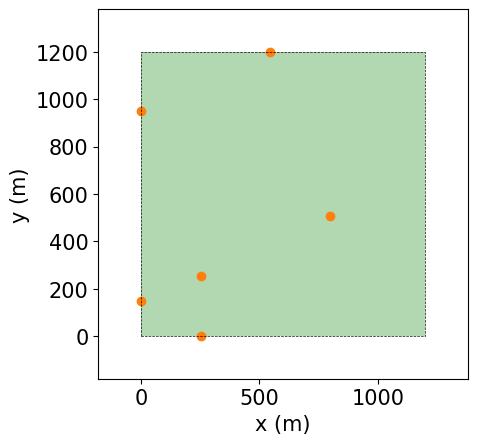

In [73]:
plot_layout(site, x_coords, y_coords)